In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from scipy.io import readsav
from scipy import ndimage
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
# import math
import glob as glob
import seaborn as sns

# PyMC 4.0 imports
import pymc as pm
import aesara.tensor as at 
import aesara
import arviz as az
import pymc.sampling_jax
import pytensor.tensor as pt
import pytensor

import sys
sys.path.append('../')

from scipy import stats

import os

from funciones.opencube2 import opencube2
from funciones.func4 import tilt,elong,MFLUX,barys,set_ranges,sizes
from funciones.modelcube import modelmag,modelmagf,modelmag2


In [13]:
def searchar(name):
    
    name=name.encode()

    matches = []
    dic=readsav('../STATS-COFFEE/stats.sav')

    for match in list(dic.arsname):
        a=0
        if name in match:
            a=1
        matches.append(a)

    ind=matches.index(1)
    
    print('nt',dic.nt[ind])
    print('time',dic.time[ind])
    print('lat',dic.latitude[ind])
    
    return dic.time[ind].decode(),dic.latitude[ind]

In [14]:

DF0=pd.read_csv('./arangosx.csv',index_col=0)

def loadar(name=None):
    
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize

    lat=searchar(str(name))[1]
    DF1=pd.read_csv('./posteriors/'+str(name)+'_TM3.csv')
    print(str(name)+'----------------------------------')
    datad,times=opencube2(name=str(name),path='../movies')
    scl=1
    
    
    nn=DF0[DF0['AR']==name].range.values[0]
    sg0=DF0[DF0['AR']==name].sigma.values[0]
    
    mask_cube=np.load('./masks/'+str(name)+'_mask.npy')[:,:,0:nn]
    data2=datad[:,:,0:nn]#*mask_cube

    sz2,sz1,nMagnetograms = (np.shape(data2))
    
    magmax=DF1.mag.max()
    stp=round(nMagnetograms/magmax)
    
    data2=data2[:,:,::stp]
    mask=mask_cube[:,:,::stp]
    
    sz2,sz1,nMagnetograms = (np.shape(data2))
    
    hem=np.sign(np.mean([barys(data2[:,:,i],20)[2]-barys(data2[:,:,i],20)[0] for i in range(nMagnetograms)]))
    
    x1 = np.linspace(0,int((sz1-1)), int((sz1)))
    y1 = np.linspace(0,int((sz2-1)), int((sz2)))
    z1 = np.linspace(0,nMagnetograms-1, nMagnetograms)
    xv, yv, zv = np.meshgrid(x1, y1,z1)
    
    params={col: np.array(DF1.groupby('mag').mean().reset_index()[col]) for col in DF1.groupby('mag').mean().reset_index().columns}
    cube,cube0=modelmag(xv,yv,params=params,hem=hem)
    
    return DF1,data2,mask,[cube,cube0]

In [34]:

DF0=pd.read_csv('./arangosx.csv',index_col=0)

def loadar2(name=None):
    
    pixsize=1.98*725*1000*100
    pixarea=pixsize*pixsize

    scl=1
    
    DF1=pd.read_csv('./posteriors2/'+str(name)+'_TM3.csv')
    nn=int(DF1.mag.max())   
    datad = np.transpose(np.load(f'../newdat/{name}_cube_data.npy'),axes=(1,2,0))[:,:,0:nn+1]
    mask_cube= np.load(f'./masks2/mask_{name}.npy')[:,:,0:nn+1]
    stp=round(nn/len(set(DF1.mag)))
    thr=0
        
    data2=datad*mask_cube
    sz2,sz1,nMagnetograms = (np.shape(data2))


        
    data2=data2[:,:,::stp]
    mask=mask_cube[:,:,::stp]
    
    sz2,sz1,nMagnetograms = (np.shape(data2))
    
    hem=np.sign(np.mean([barys(data2[:,:,i],20)[2]-barys(data2[:,:,i],20)[0] for i in range(nMagnetograms)]))
    
    x1 = np.linspace(0,int((sz1-1)), int((sz1)))
    y1 = np.linspace(0,int((sz2-1)), int((sz2)))
    z1 = np.linspace(0,nMagnetograms-1, nMagnetograms)
    xv, yv, zv = np.meshgrid(x1, y1,z1)
    
    params={col: np.array(DF1.groupby('mag').mean().reset_index()[col]) for col in DF1.groupby('mag').mean().reset_index().columns}
    cube,cube0=modelmag(xv,yv,params=params,hem=hem)
    
    return DF1,data2,mask,[cube,cube0]

In [15]:


def plotmags(array1=None,array2=None,mask=None):
    
    
    # Definir tamaños de fuente
    title_fontsize = 18
    axis_label_fontsize = 16
    tick_label_fontsize = 16
    
    # Crear la figura y los ejes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6),sharey=True)

    # Definir los límites y el mapa de colores
    vmin, vmax = -50, 50
    bounds = [-60, -50, 0, 50, 60]
    lev=100
    

    # Primer panel
    c1 = axs[0].imshow(array1,origin='lower',interpolation='bilinear', cmap='bwr',vmin=-2000,vmax=2000)
    axs[0].set_title('SOHO/MDI', fontsize=title_fontsize)
    xp,yp,xn,yn = barys(array1*mask,20)
    axs[0].contour(array1, levels=[-lev, lev],linestyles=['dashed','solid'],colors=['blue','red'])
    c2 = axs[0].imshow(mask,origin='lower',interpolation='quadric',cmap='YlOrBr',vmin=0,vmax=3,alpha=0.5)    
    


    # Segundo panel
    c2 = axs[1].imshow(array2,origin='lower', cmap='bwr',interpolation='bilinear',vmin=-2000,vmax=2000)
    axs[1].set_title('Model', fontsize=title_fontsize)
    axs[1].yaxis.set_ticks_position('right')  # Mover los ticks y etiquetas del eje y al lado derecho
    axs[1].yaxis.set_label_position('right')
  #  axs[1].set_yticks([])
    axs[1].contour(array2, levels=[-lev, lev],linestyles=['dashed','solid'],colors=['blue','red'])
    
    
    # Configuración de los ticks y etiquetas
    for i in [0,1]:
        axs[i].tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
        axs[i].set_xlabel('X (pixels)', fontsize=axis_label_fontsize)
        axs[i].set_ylabel('Y (pixels)', fontsize=axis_label_fontsize)
        axs[i].plot([xp,xn],[yp,yn],color='black')

    # Añadir una barra de color
    cbar = fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.03, pad=0.1)
    cbar.set_label(r'$B_z$')
    cbar.ax.tick_params(labelsize=tick_label_fontsize)

    # Ajustar el layout y mostrar la figura
    plt.tight_layout()
  #  plt.show()

    return fig

In [51]:
searchar('9290')

nt 0.11672378
time b'30-Dec-2000 06:27:01.305'
lat 30


('30-Dec-2000 06:27:01.305', 30)

In [ ]:
for names in list(DF0['AR'].values):
    DF,mags,mask,mod=loadar(name=names)
    np.save('./models/'+str(names)+'.npy',mod[0])
    

nt 0.22970201
time b'23-Sep-2002 03:11:01.323'
lat 6
10132----------------------------------
133 123 33
b'21-Sep-2002 22:23:01.298' b'24-Sep-2002 03:11:01.344'
75 84
nt 0.27008736
time b'29-Mar-2003 20:48:00.534'
lat -7
10323----------------------------------
155 193 68
b'27-Mar-2003 14:24:00.501' b'1-Apr-2003 03:12:00.557'
96 159
nt 0.099744365
time b'27-Apr-2003 19:12:00.360'
lat 16
10344----------------------------------
231 171 68
b'25-Apr-2003 16:03:00.390' b'30-Apr-2003 04:47:00.310'
73 119
nt -0.3175573
time b'11-Jun-2003 11:10:59.370'
lat -18
10381----------------------------------
145 137 57
b'9-Jun-2003 22:22:59.390' b'13-Jun-2003 17:34:59.340'
70 88
nt -0.100707754
time b'7-Mar-2004 09:39:03.290'
lat -11
10569----------------------------------
96 119 68
b'4-Mar-2004 19:15:03.230' b'9-Mar-2004 08:03:03.330'
71 103
nt -0.22048052
time b'3-May-2006 14:23:01.490'
lat 16
10879----------------------------------
143 151 65
b'1-May-2006 11:11:01.530' b'5-May-2006 19:11:01.450'
71 96

In [38]:
for names in list(DF0['AR'].values):
#for names in [9884]:
    try:
        DF,mags,mask,mod=loadar2(name=names)
        np.save('./models2/'+str(names)+'.npy',mod[0])
    except:
        print('No AR found')
    

No AR found
No AR found
No AR found
No AR found
No AR found
No AR found


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:84: RuntimeWarning: invalid value encountered in scalar divide
  xp=np.sum(xv[data>thr]*data[data>thr])/np.sum(data[data>thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:87: RuntimeWarning: invalid value encountered in scalar divide
  yp=np.sum(yv[data>thr]*data[data>thr])/np.sum(data[data>thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])


No AR found
No AR found


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:84: RuntimeWarning: invalid value encountered in scalar divide
  xp=np.sum(xv[data>thr]*data[data>thr])/np.sum(data[data>thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:87: RuntimeWarning: invalid value encountered in scalar divide
  yp=np.sum(yv[data>thr]*data[data>thr])/np.sum(data[data>thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])


No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])


No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found
No AR found


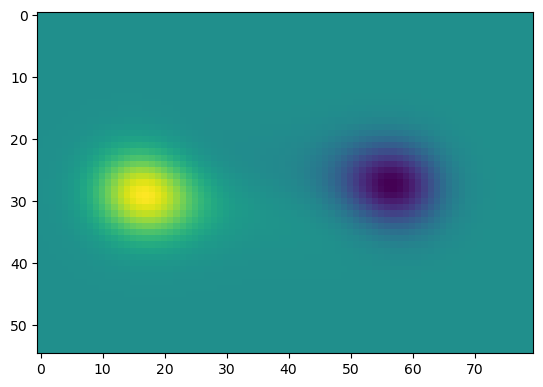

In [37]:
plt.imshow(mod[0][:,:,20])

In [81]:
[ 9290,
 9417,
 8407,
 10569,
 8628,
 8167,
 9710]

[9290, 9417, 8407, 10569, 8628, 8167, 9710]

[10132 10323 10344 10381 10569 10879 10900 10971 11024  8088  8122  8130
  8164  8167  8171  8214  8226  8476  8582  8614  8628 10043 10045 10050
 10099 10103 10130 10137 10144 10188 10226 10311 10349 10385 10391 10456
 10547 10747 10987 11007  7982  8016  8040  8052  8084  8193  8205  8404
  8407  8488  8524  8536  8552  8589  8649  8690  8699 10268 10274  8056
  8060  8722  8749  8757  8760  8797  8828  8851  8898  8900  8913  8924
  8968  8972  8986  9032  9035  9063  9069  9070  9103  9139  9140  9144
  9154  9170  9192  9218  9267  9290  9291  9308  9311  9368  9396  9399
  9417  9432  9441  9455  9456  9484  9511  9512  9531  9548  9563  9569
  9574  9660  9678  9689  9710  9764  9844  9845  9873  9880  9884  9897
  9906  9910  9912  9931  9978  9987] 9290


/tmp/ipykernel_1191/2873066945.py:33: UserWarning: No contour levels were found within the data range.
  axs[1].contour(array2, levels=[-lev, lev],linestyles=['dashed','solid'],colors=['blue','red'])
/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


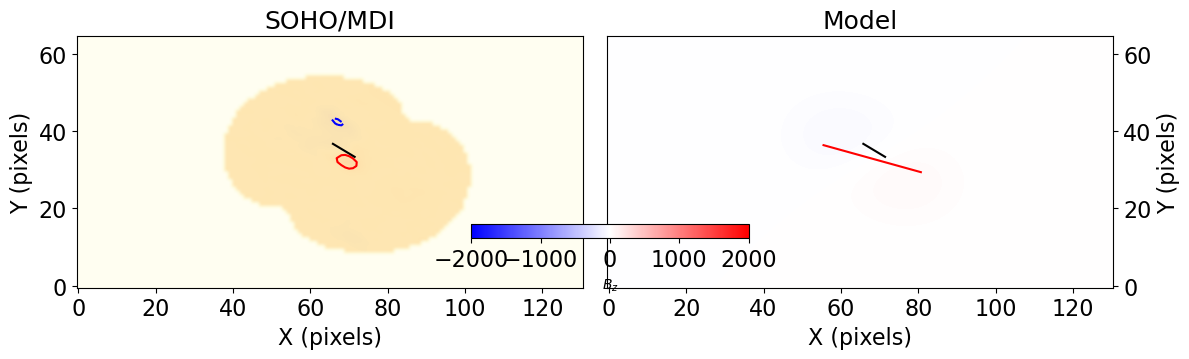

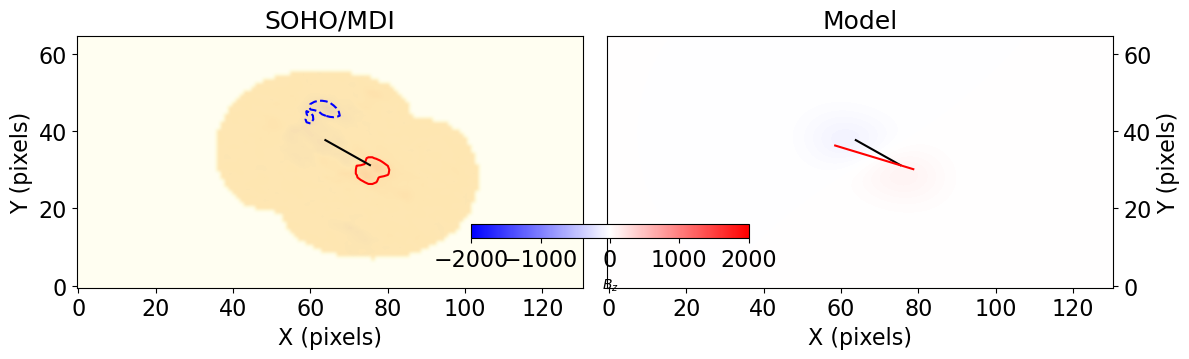

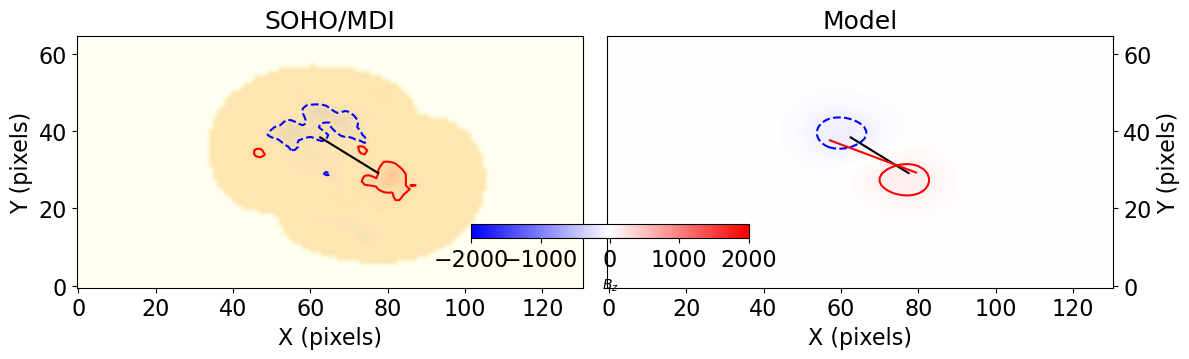

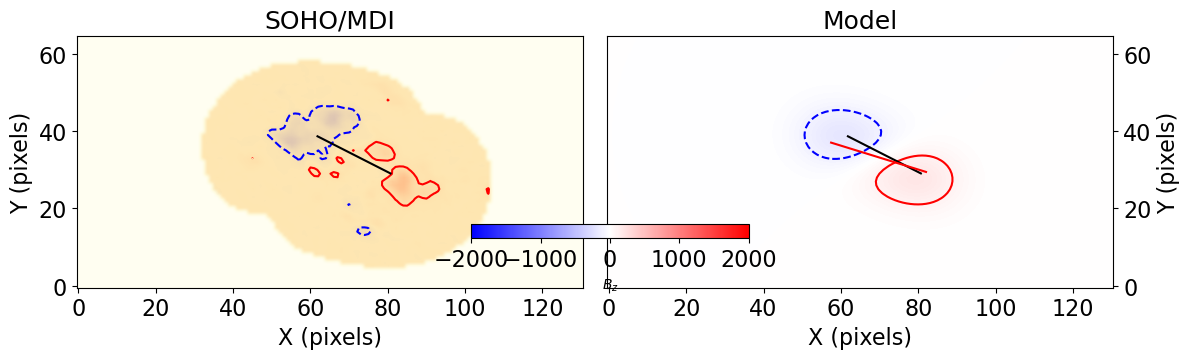

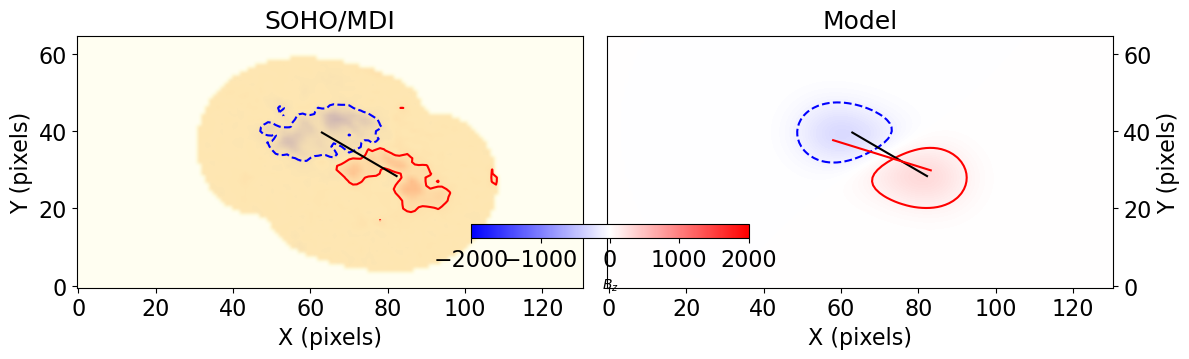

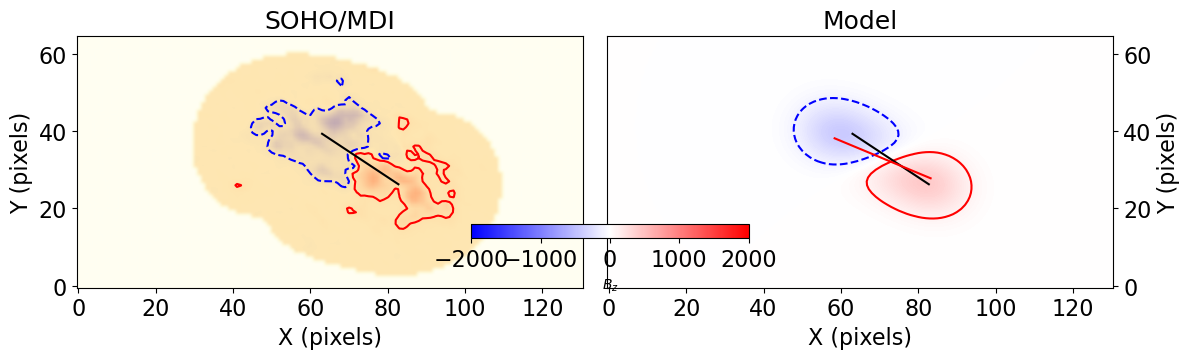

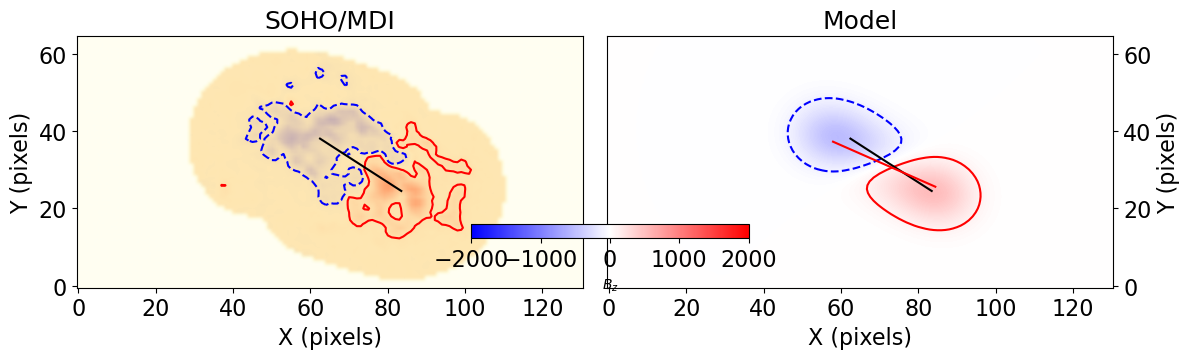

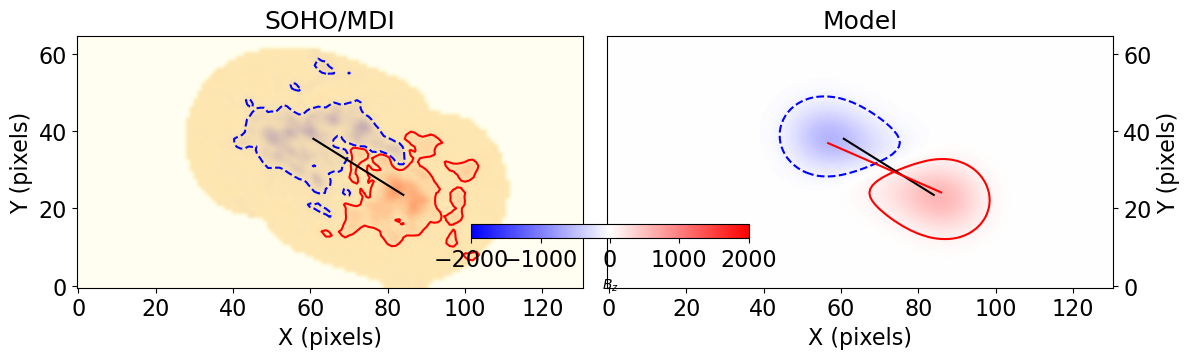

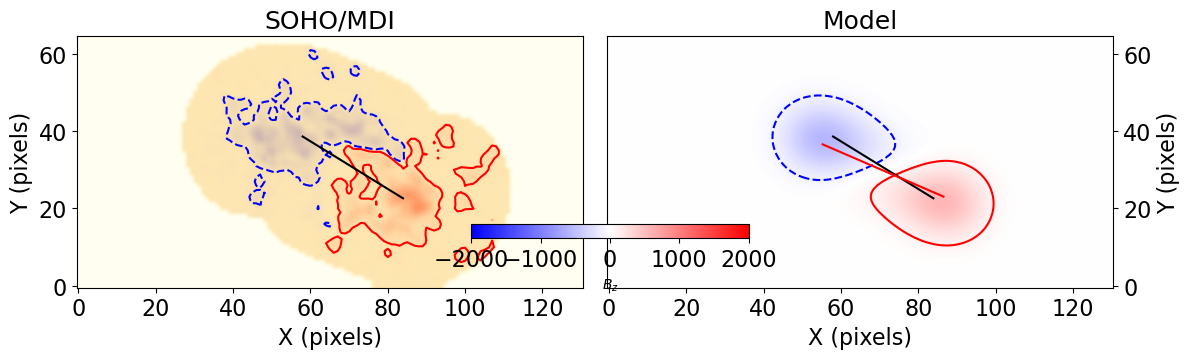

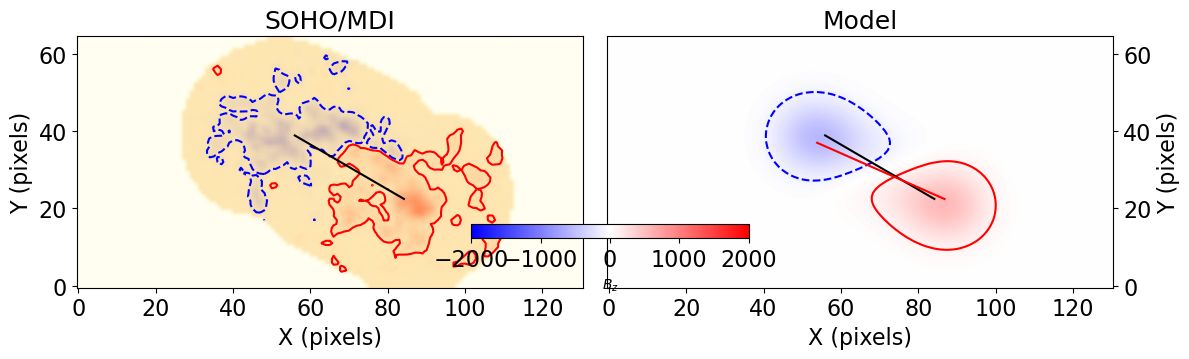

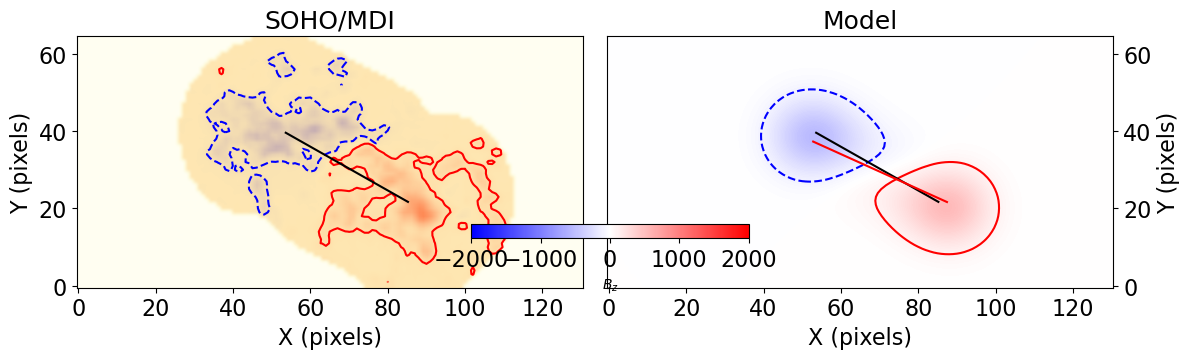

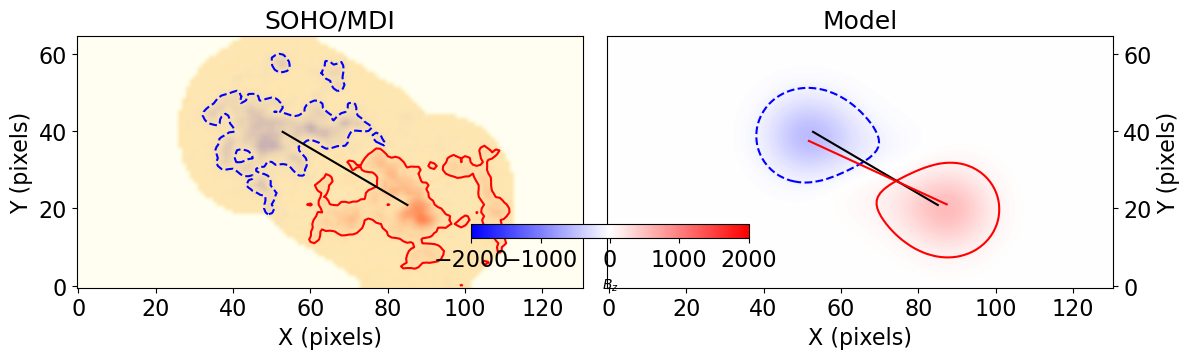

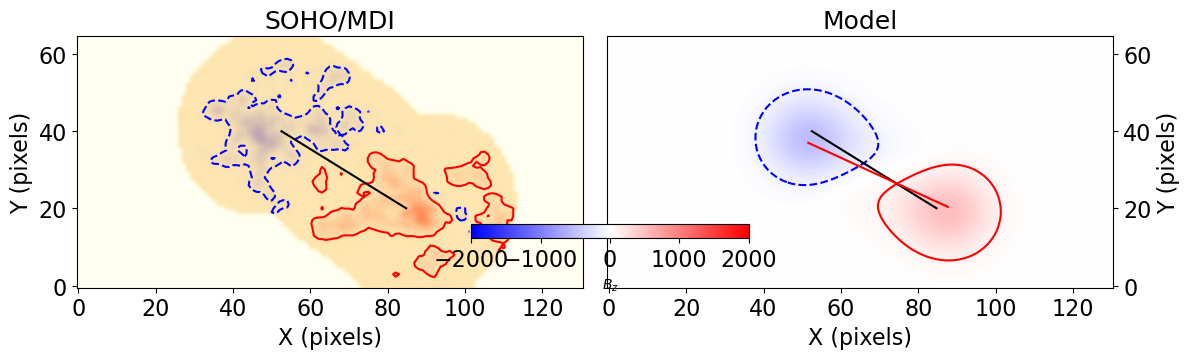

In [39]:
ar=int(input(DF0['AR'].values))
DF,mags,mask,mod=loadar2(name=ar)
params={col: np.array(DF.groupby('mag').mean().reset_index()[col]) for col in DF.groupby('mag').mean().reset_index().columns}


#for p,i in enumerate([2,int(np.shape(mags)[2]/2),int(np.shape(mags)[2]-1)]):
for p,i in enumerate(range(0,np.shape(mags)[2]-1,3)):

    fig=plotmags(array1=mags[:,:,i],array2=mod[0][:,:,i],mask=mask[:,:,i])
    xp,yp,xn,yn = barys(mod[1][:,:,i],20)

    axs=fig.gca()
    axs.plot([xp,xn],[yp,yn],color='red')

  #  axs.set_ylim(10,55)


    plt.show()

   # fig.savefig('./plots/ARmag-'+str(p)+'.pdf',dpi=300)

In [42]:
DF[DF['mag']==0.0]

,Unnamed: 0,da,alpha,a,R,N0,axf,xc,yc,mag
0,0,0.035711,-0.280633,3.840344,9.447770,-0.764025,166482.853535,34.680954,34.08104,0.0
1,1,0.020338,-0.264215,3.813308,9.493943,-0.777869,165179.751350,34.680954,34.08104,0.0
2,2,0.014690,-0.241945,4.181324,9.412483,-0.743068,168849.890866,34.680954,34.08104,0.0
3,3,0.029301,-0.331681,4.017506,9.447801,-0.769427,165674.107766,34.680954,34.08104,0.0
4,4,0.026588,-0.293841,3.875161,9.414367,-0.771584,164745.928929,34.680954,34.08104,0.0
...,...,...,...,...,...,...,...,...,...,...
3995,3995,0.012998,-0.304271,3.896553,9.415588,-0.773436,165449.266642,34.680954,34.08104,0.0
3996,3996,0.009600,-0.279506,3.820281,9.419895,-0.771077,164569.112839,34.680954,34.08104,0.0
3997,3997,0.024492,-0.265773,3.859269,9.408573,-0.754624,167868.797521,34.680954,34.08104,0.0
3998,3998,0.026566,-0.204945,3.891390,9.456032,-0.755839,167086.207154,34.680954,34.08104,0.0


In [17]:
err={col: np.array(DF.groupby('mag').std().reset_index()[col]) for col in DF.groupby('mag').mean().reset_index().columns}

In [18]:
# Función para redondear a dos cifras significativas
def round_to_significant(x, sig=1):
    return round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)

# Función para mostrar la cantidad con su error
def mostrar_con_error(cantidad, error,units=None):
    error_redondeado = round_to_significant(error, 1)
    decimales = -int(np.floor(np.log10(error_redondeado))) if error_redondeado != 0 else 0
    cantidad_redondeada = round(cantidad, decimales)
    
    return f"({cantidad_redondeada} ± {error_redondeado})"+units


resultado = mostrar_con_error(params['da'][0], err['da'][0],units=r'deg')
print(resultado)

(0.05 ± 0.05)deg


In [10]:
int(np.shape(mags)[2])

48

In [40]:
f=np.sum(np.abs(mags),axis=(0,1))

In [41]:
fn=f/np.max(f)

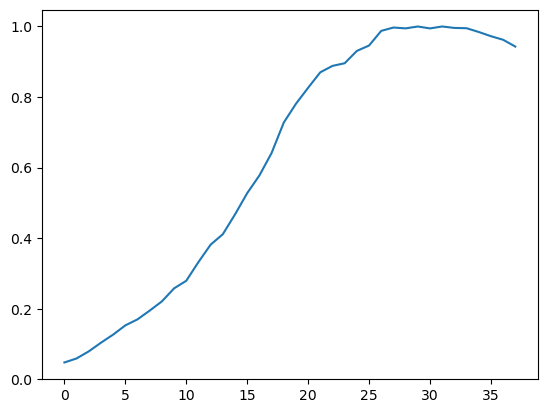

In [42]:
plt.plot(fn)

/tmp/ipykernel_1191/2873066945.py:33: UserWarning: No contour levels were found within the data range.
  axs[1].contour(array2, levels=[-lev, lev],linestyles=['dashed','solid'],colors=['blue','red'])
/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


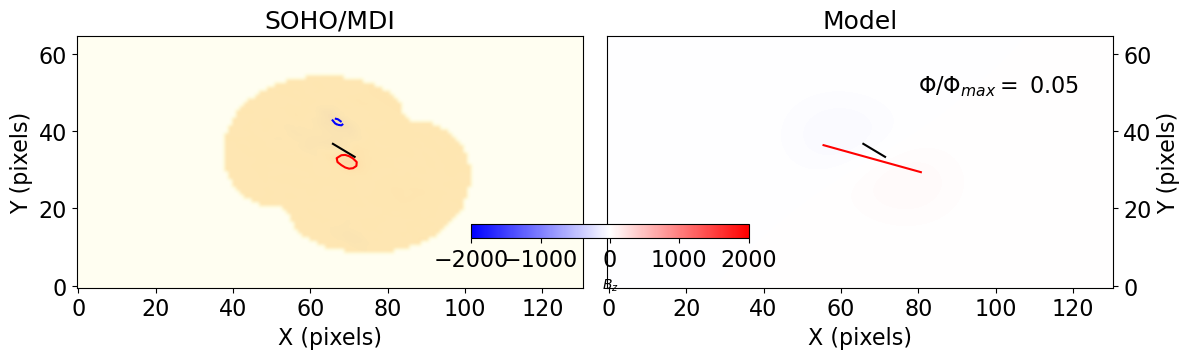

/tmp/ipykernel_1191/2873066945.py:33: UserWarning: No contour levels were found within the data range.
  axs[1].contour(array2, levels=[-lev, lev],linestyles=['dashed','solid'],colors=['blue','red'])
/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


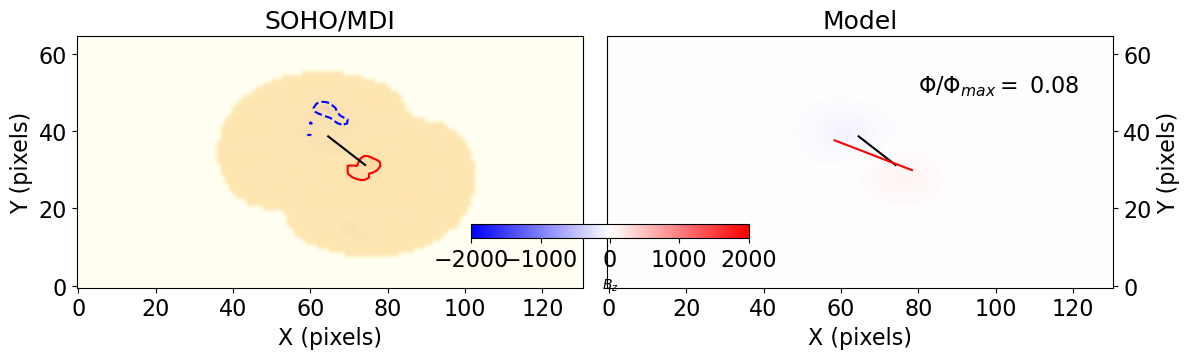

/tmp/ipykernel_1191/2873066945.py:33: UserWarning: No contour levels were found within the data range.
  axs[1].contour(array2, levels=[-lev, lev],linestyles=['dashed','solid'],colors=['blue','red'])
/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


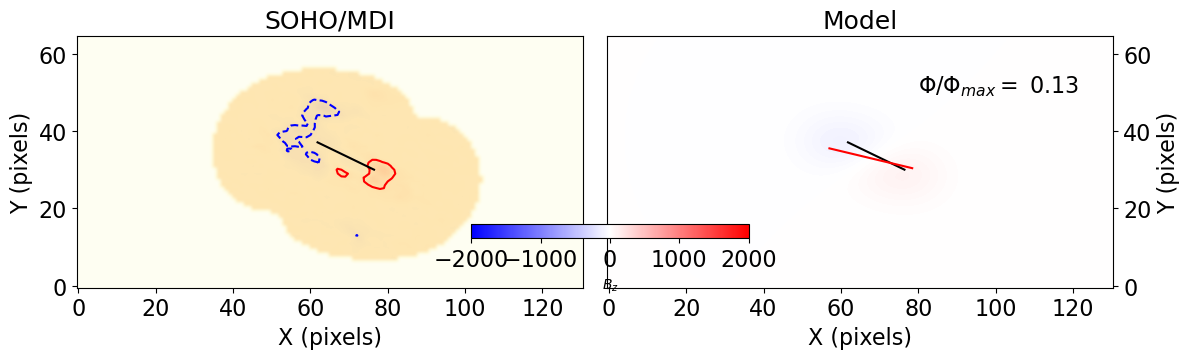

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


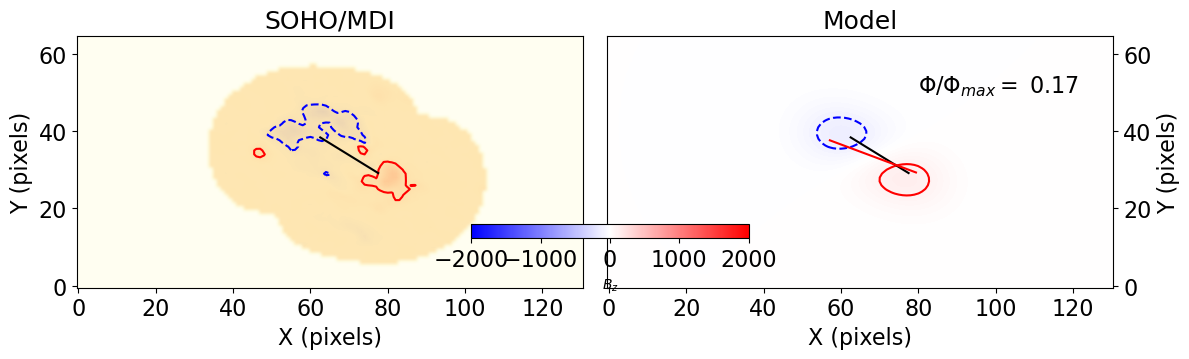

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


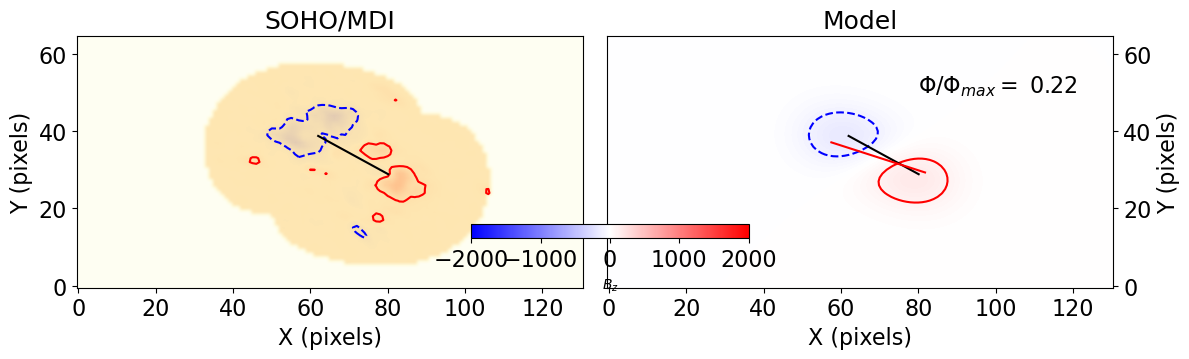

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


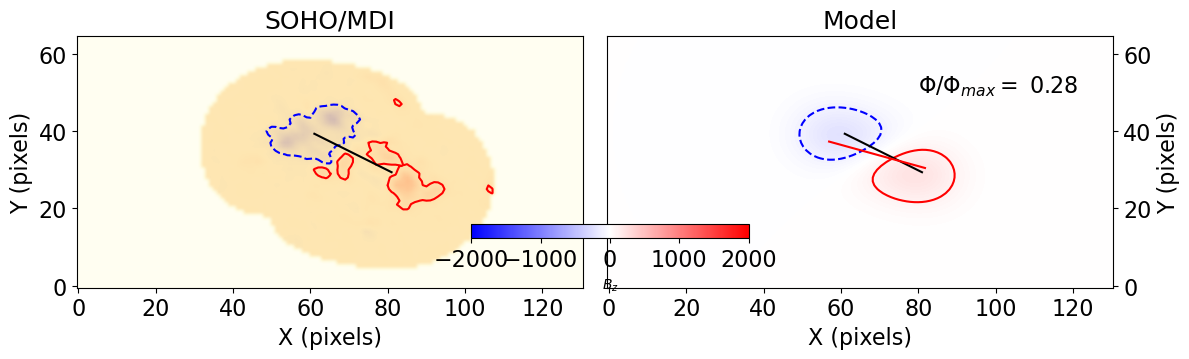

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


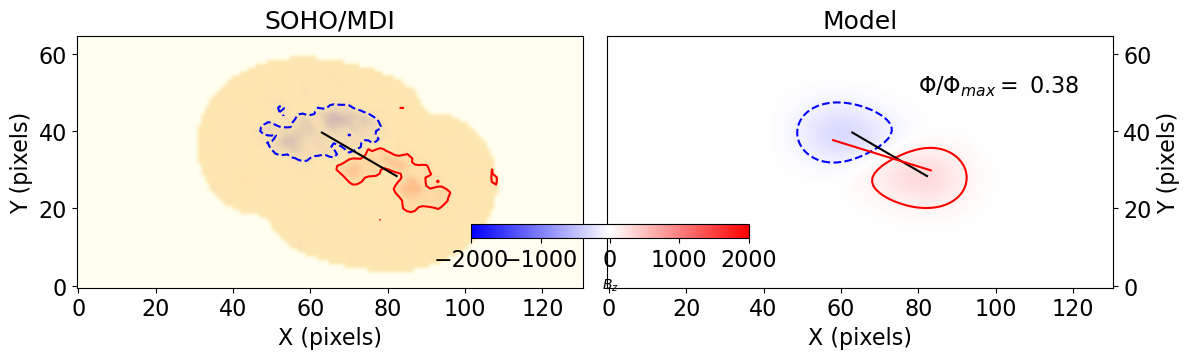

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


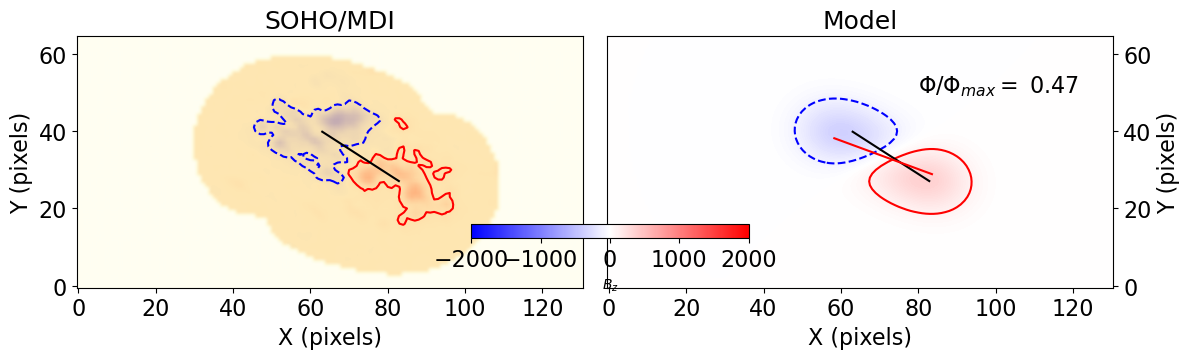

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


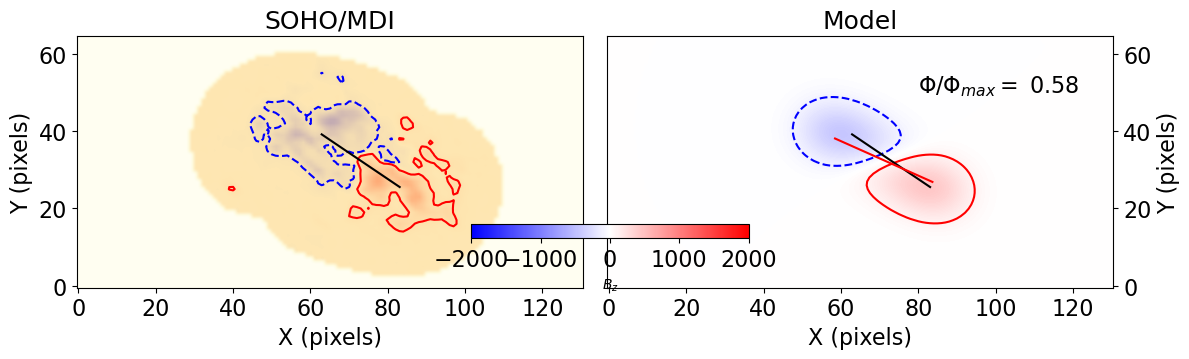

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


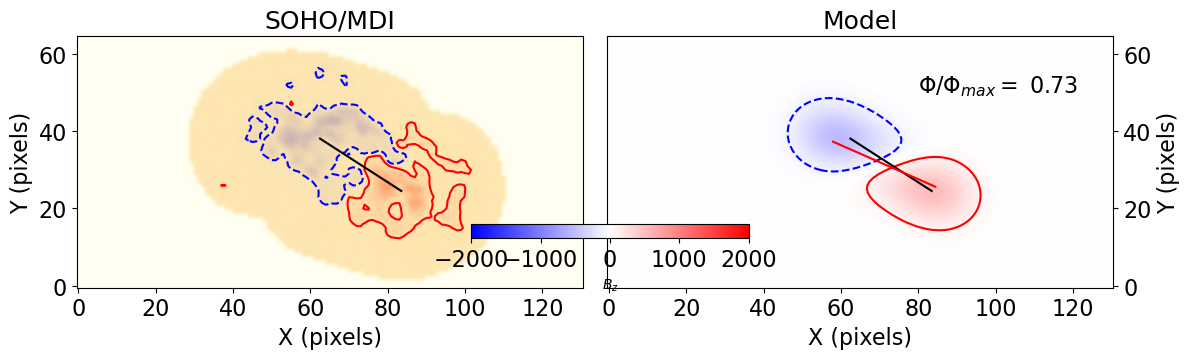

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


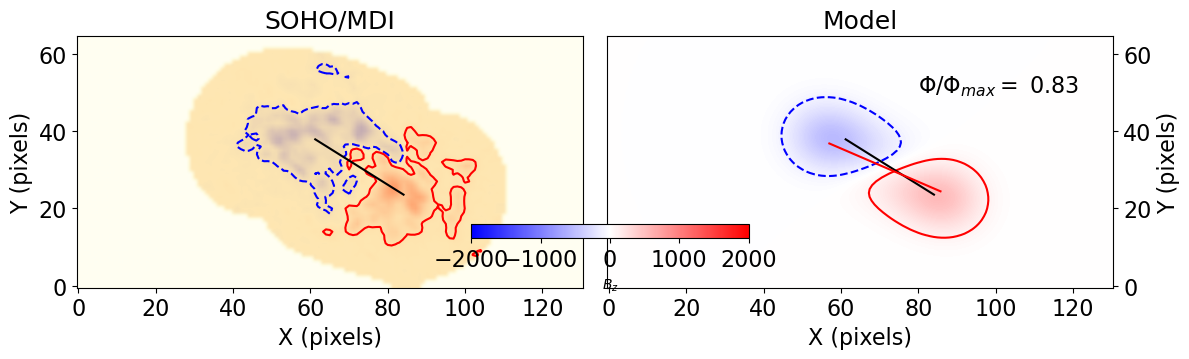

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


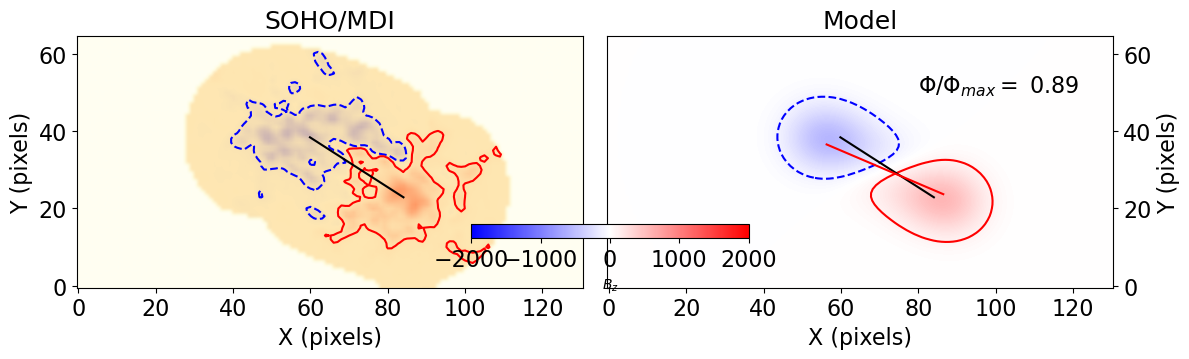

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


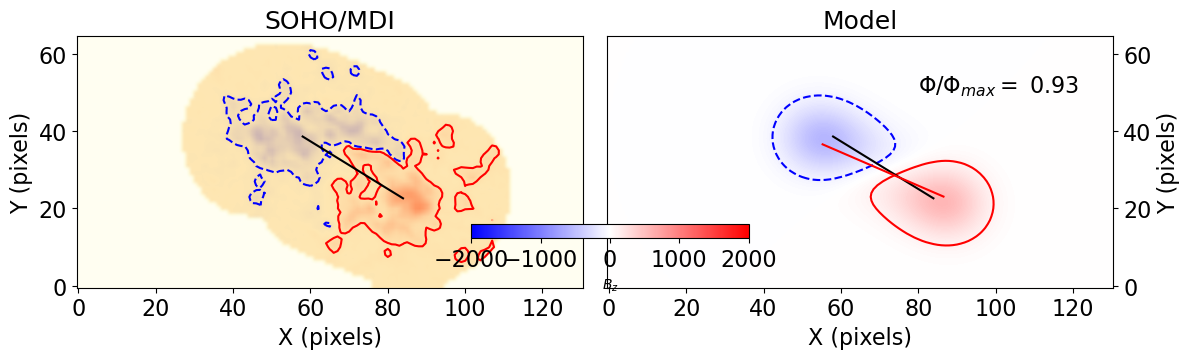

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


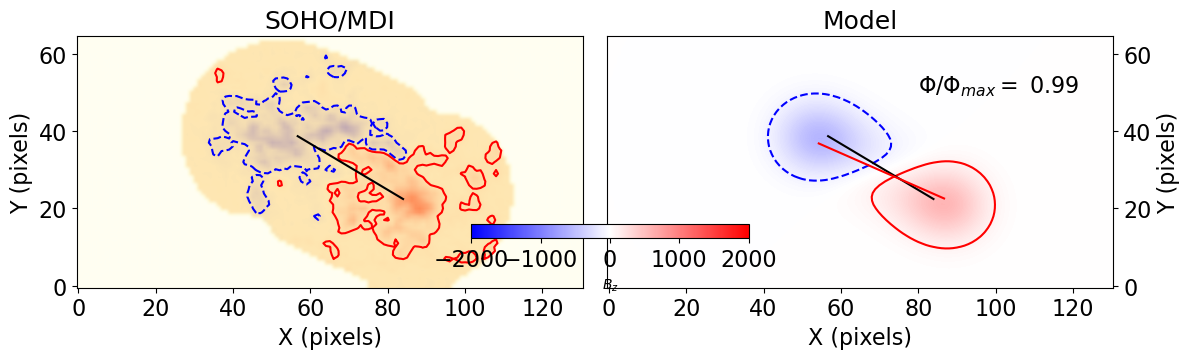

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


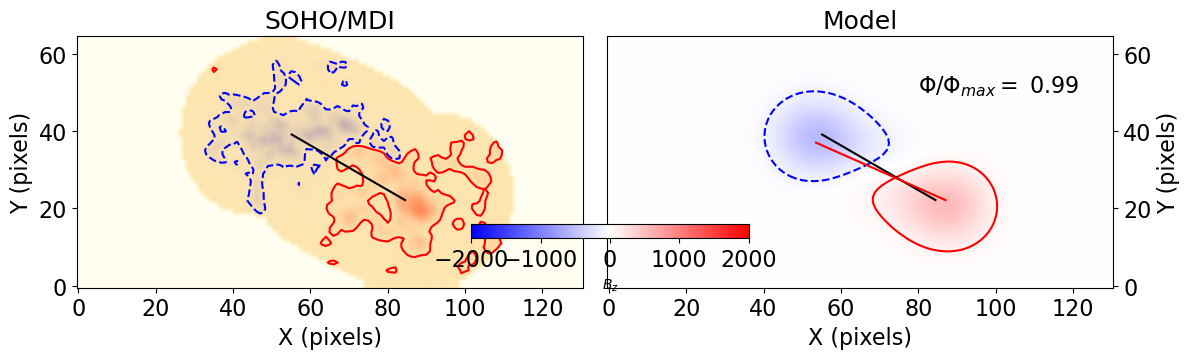

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


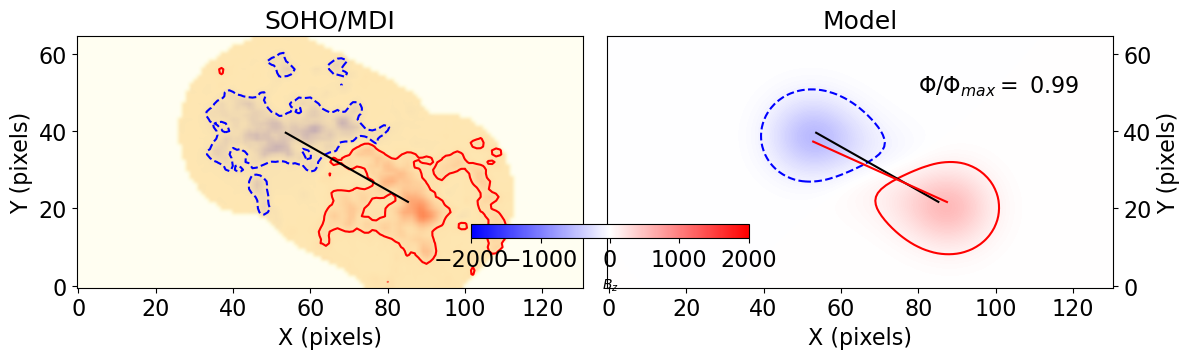

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


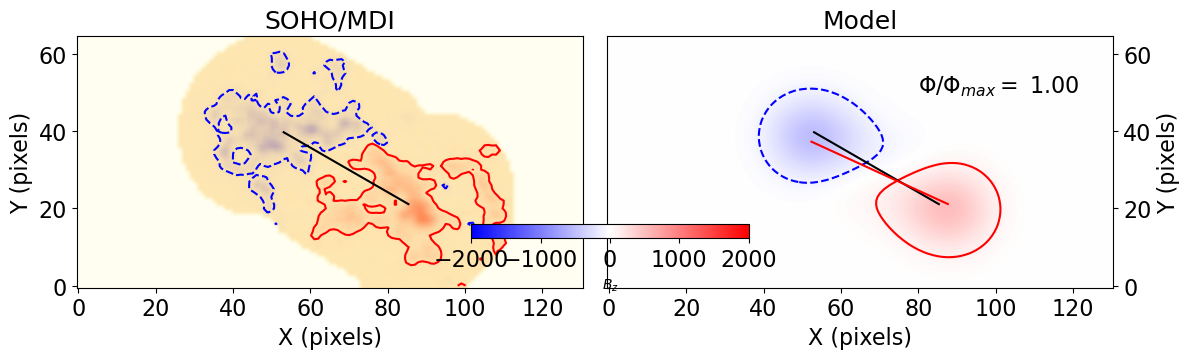

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


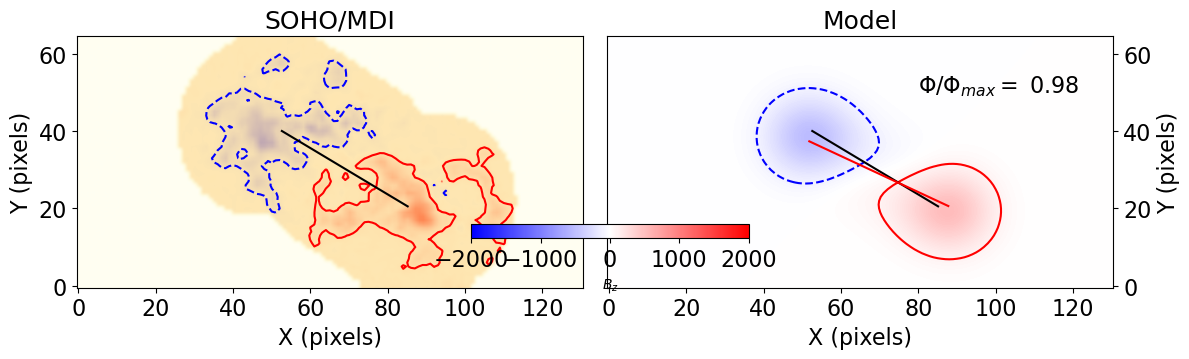

/tmp/ipykernel_1191/2873066945.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


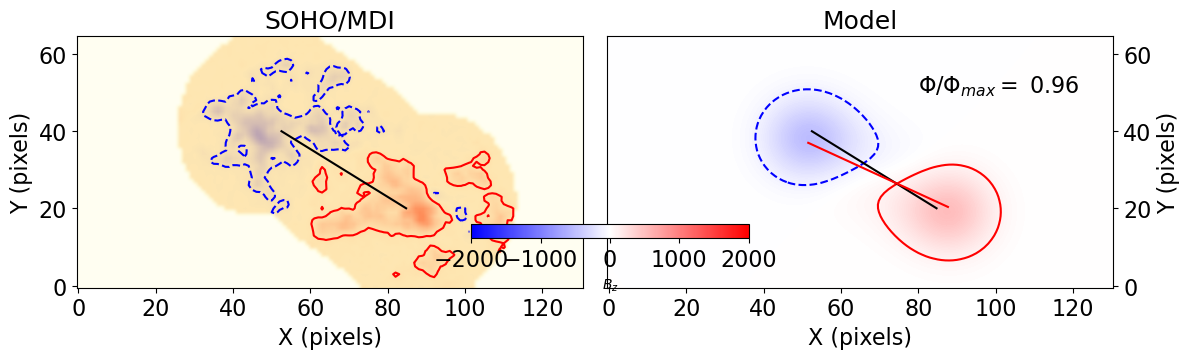

In [49]:



for p,i in enumerate(range(0,int(np.shape(mags)[2]),2)):
    fig=plotmags(array1=mags[:,:,i],array2=mod[0][:,:,i],mask=mask[:,:,i])
    xp,yp,xn,yn = barys(mod[1][:,:,i],20)

    axs=fig.gca()
    axs.plot([xp,xn],[yp,yn],color='red')
    
    axs.text(80,50,fr'$\Phi/\Phi_{{max}} =$ {fn[i]:.2f}', fontsize=16)

   # axs.set_ylim(10,55)
 #   axs.text(30,20,r'$d_0$ = '+mostrar_con_error(params['da'][i], err['da'][i],units=''), fontsize=16)
 #   axs.text(30,16,r'$\alpha$ = '+mostrar_con_error(180*params['alpha'][i]/np.pi, 180*err['alpha'][i]/np.pi,units=r' deg'), fontsize=16)
 #   axs.text(30,12,r'$a$ = '+mostrar_con_error(params['a'][i], err['a'][i],units=r' pix'), fontsize=16)
 #   axs.text(80,60,r'Mag '+str(i+1), fontsize=16)
    
    plt.show()

    fig.savefig('./plotilt/ARmag-'+str(p)+'.pdf',dpi=300)